# 9.2 Techniki regularyzacyjne - batch-norm

W tym skrypcie znajdziemy wyniki eksperymentów opisanych w rozdziale 9.2 ,,Techniki regularyzacyjne'', które dotyczą  mechanizmu ,,batch-norm'' czyli normalizacji danych w poszczególnych warstwach sieci.


### Importowanie niezbędnych modułow

In [ ]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm.notebook import tqdm

Klasa ,,*AverageMeter*'' przechowuje oraz przetwarza częściowe wyniki zapisywane w poszczególnych etapach uczenia modelu. Funkcja ,,*accuracy*'' liczy dokładność sieci w procesie uczenia lub jej walidacji.

In [2]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum = self.sum + val * n
        self.count = self.count + n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=[1]):
    max_k = np.max(topk)
    batch_size = target.shape[0]

    _, pred = output.topk(max_k, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    results = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        results.append(correct_k.mul_(100.0 / batch_size))
    return results

W tej części przygotowujemy zbiór danych do trenowania i walidacji modelu. Przetwarzamy obrazki ze zbioru *Cifar-10* do tensorów, które są pobierane iteracyjnie w batchach podczas trenowania sieci (zmienne: ,,*train_loader*'', ,,*test_loader*'').

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset = 'fmnist'  # Fashion MNIST
dataset = "cifar-10"
root = "/datasets"
download = False

if dataset == "cifar-10":
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = datasets.CIFAR10(
        root=root, train=True, download=download, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=64, shuffle=True, num_workers=2
    )

    testset = datasets.CIFAR10(
        root=root, train=False, download=download, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=2
    )
elif dataset == "fmnist":
    transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

    train_set = datasets.FashionMNIST(
        f"{root}/fmnist/", download=download, train=True, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

    test_set = datasets.FashionMNIST(
        f"{root}/fmnist/", download=download, train=False, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
else:
    print("Choose dataset from: cifar-10, fmnist")

# Model LeNet bez regularyzacji *batch-norm*

Poniżej definujemy klasy *LeNet5*, w której tworzymy sieć neuronową bez regularyzacji *batch-norm*.

In [4]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1 if dataset == "fmnist" else 3,
                out_channels=6,
                kernel_size=5,
                stride=1,
            ),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            torch.nn.ReLU(True),
        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = torch.flatten(x, 1)
        return self.linear_layers(x)

Uczenie modelu i jego walidacja.

In [ ]:
model = LeNet5().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

scores = {
    "train": {"loss": [], "Prec@1": [], "Prec@5": []},
    "test": {"loss": [], "Prec@1": [], "Prec@5": []},
}

print("The results are described by: (loss, Prec@1, Prec@5)")
epochs = 25
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, target in train_tqdm:
        image, target = image.to(device), target.to(device)

        output = model(image)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        prec1, prec5 = accuracy(torch.softmax(output, dim=1), target, topk=(1, 5))
        losses.update(loss.item(), image.shape[0])
        top1.update(prec1.item(), image.shape[0])
        top5.update(prec5.item(), image.shape[0])

        train_tqdm.set_description(
            f"TRAIN [loss, P@1, P@5]: [{losses.val:.4f} ({losses.avg:.4f}),{top1.val:2.2f} "
            f"({top1.avg:2.2f}),{top5.val:2.2f} ({top5.avg:2.2f})]"
        )

    scores["train"]["loss"].append(losses.avg)
    scores["train"]["Prec@1"].append(top1.avg)
    scores["train"]["Prec@5"].append(top5.avg)

    # validating
    model.eval()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, target in eval_tqdm:
            image, target = image.to(device), target.to(device)

            output = model(image)
            loss = criterion(output, target)

            prec1, prec5 = accuracy(torch.softmax(output, dim=1), target, topk=(1, 5))
            losses.update(loss.item(), image.shape[0])
            top1.update(prec1.item(), image.shape[0])
            top5.update(prec5.item(), image.shape[0])

            eval_tqdm.set_description(
                f"TEST [loss, P@1, P@5]: [{losses.val:.4f} ({losses.avg:.4f}),{top1.val:2.2f} "
                f"({top1.avg:2.2f}),{top5.val:2.2f} ({top5.avg:2.2f})]"
            )

    scores["test"]["loss"].append(losses.avg)
    scores["test"]["Prec@1"].append(top1.avg)
    scores["test"]["Prec@5"].append(top5.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]\t"
        f"train: ({scores['train']['loss'][-1]:.4f},{scores['train']['Prec@1'][-1]:2.2f},"
        f"{scores['train']['Prec@5'][-1]:2.2f})\t"
        f"test: ({scores['test']['loss'][-1]:.4f},{scores['test']['Prec@1'][-1]:2.2f},"
        f"{scores['test']['Prec@5'][-1]:2.2f})"
    )

# Model LeNet z regularyzacją *batch-norm*

Poniżej definujemy klasy *LeNet5_bnorm*, w której tworzymy sieć neuronową z regularyzacją *batch-norm*.

In [6]:
class LeNet5_bnorm(torch.nn.Module):
    def __init__(self):
        super(LeNet5_bnorm, self).__init__()

        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1 if dataset == "fmnist" else 3,
                out_channels=6,
                kernel_size=5,
                stride=1,
            ),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            torch.nn.ReLU(True),
        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm1d(84),
            torch.nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = torch.flatten(x, 1)
        return self.linear_layers(x)

Zapisujemy poszczególne wyniki trenowania modelu do słownika w celu porównania ich z wynikami sieci neuronowej z regularyzacją *batch-norm*.

In [7]:
total_scores = {'LeNet5': scores}

Uczenie modelu i jego walidacja.

In [ ]:
model = LeNet5_bnorm().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

scores = {
    "train": {"loss": [], "Prec@1": [], "Prec@5": []},
    "test": {"loss": [], "Prec@1": [], "Prec@5": []},
}

print("The results are described by: (loss, Prec@1, Prec@5)")
epochs = 25
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, target in train_tqdm:
        image, target = image.to(device), target.to(device)

        output = model(image)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        prec1, prec5 = accuracy(torch.softmax(output, dim=1), target, topk=(1, 5))
        losses.update(loss.item(), image.shape[0])
        top1.update(prec1.item(), image.shape[0])
        top5.update(prec5.item(), image.shape[0])

        train_tqdm.set_description(
            f"TRAIN [loss, P@1, P@5]: "
            f"[{losses.val:.4f} ({losses.avg:.4f}),{top1.val:2.2f} "
            f"({top1.avg:2.2f}),{top5.val:2.2f} ({top5.avg:2.2f})]"
        )

    scores["train"]["loss"].append(losses.avg)
    scores["train"]["Prec@1"].append(top1.avg)
    scores["train"]["Prec@5"].append(top5.avg)

    # validating
    model.eval()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, target in eval_tqdm:
            image, target = image.to(device), target.to(device)

            output = model(image)
            loss = criterion(output, target)

            prec1, prec5 = accuracy(torch.softmax(output, dim=1), target, topk=(1, 5))
            losses.update(loss.item(), image.shape[0])
            top1.update(prec1.item(), image.shape[0])
            top5.update(prec5.item(), image.shape[0])

            eval_tqdm.set_description(
                f"TEST [loss, P@1, P@5]: "
                f"[{losses.val:.4f} ({losses.avg:.4f}),{top1.val:2.2f} "
                f"({top1.avg:2.2f}),{top5.val:2.2f} ({top5.avg:2.2f})]"
            )

    scores["test"]["loss"].append(losses.avg)
    scores["test"]["Prec@1"].append(top1.avg)
    scores["test"]["Prec@5"].append(top5.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]\t"
        f"train: ({scores['train']['loss'][-1]:.4f},{scores['train']['Prec@1'][-1]:2.2f},"
        f"{scores['train']['Prec@5'][-1]:2.2f})\t"
        f"test: ({scores['test']['loss'][-1]:.4f},{scores['test']['Prec@1'][-1]:2.2f},"
        f"{scores['test']['Prec@5'][-1]:2.2f})"
    )

Poniżej przedstawiamy wyniki powyższych dwóch modeli w postaci wykresów. Na pierwszym pokazujemy dokładność modeli w poszczególnych etapach ich uczenia, zaś na drugim wykresie przedstawiamy jak zmienia się funkcja kosztu w czasie ich uczenia.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2.5)
sns.set_style("whitegrid")

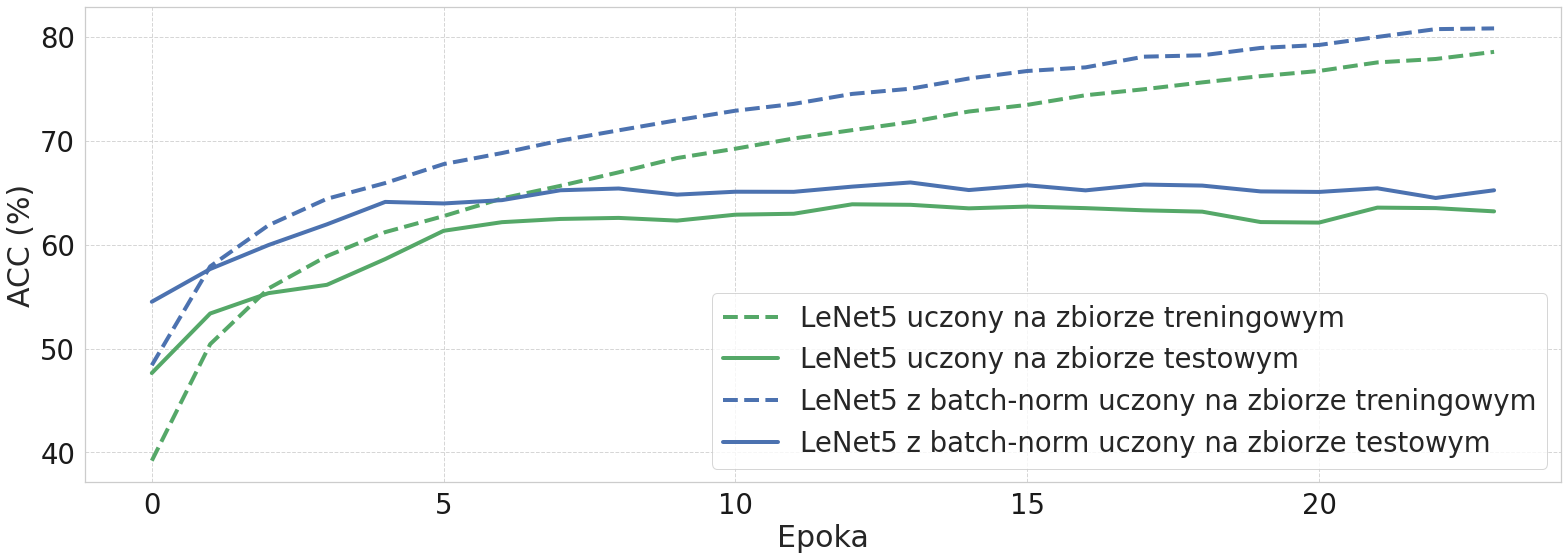

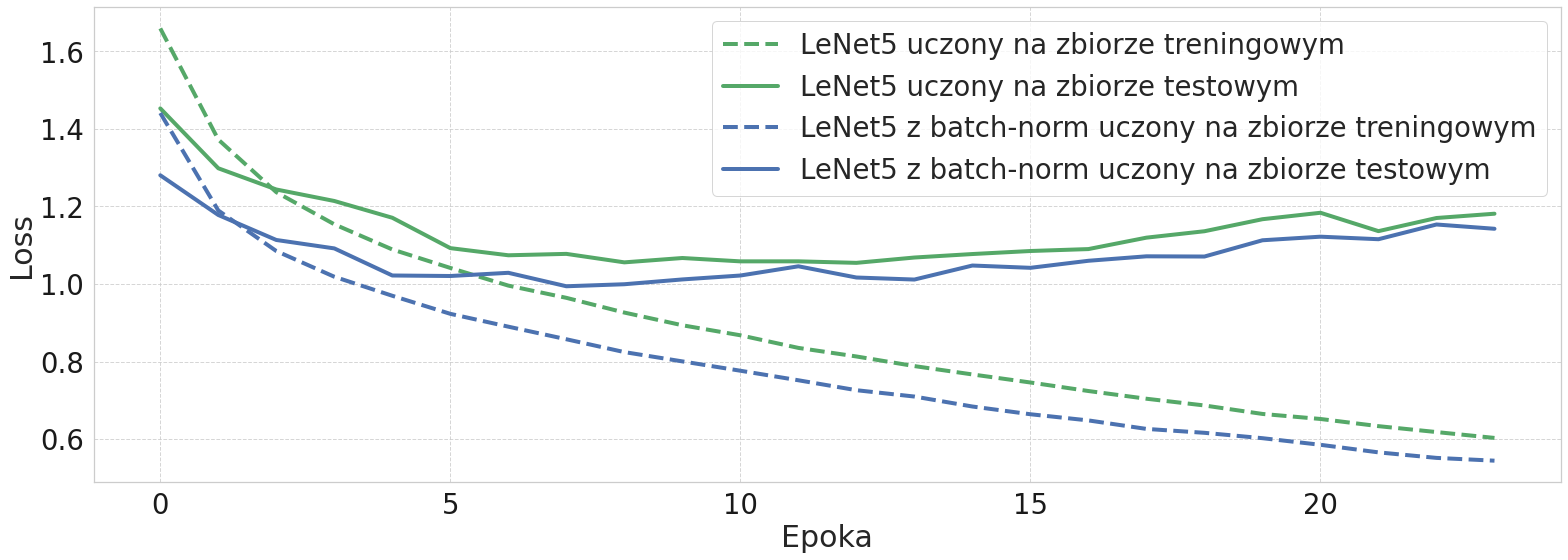

In [11]:
# Prec@1
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    total_scores["LeNet5"]["train"]["Prec@1"],
    "g--",
    linewidth=4,
    markersize=12,
    label="LeNet5 uczony na zbiorze treningowym",
)
ax.plot(
    total_scores["LeNet5"]["test"]["Prec@1"],
    "g-",
    linewidth=4,
    markersize=12,
    label="LeNet5 uczony na zbiorze testowym",
)
ax.plot(
    total_scores["LeNet5_bnorm"]["train"]["Prec@1"],
    "b--",
    linewidth=4,
    markersize=12,
    label="LeNet5 z batch-norm uczony na zbiorze treningowym",
)
ax.plot(
    total_scores["LeNet5_bnorm"]["test"]["Prec@1"],
    "b-",
    linewidth=4,
    markersize=12,
    label="LeNet5 z batch-norm uczony na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("ACC (%)")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

# plt.savefig('./cnn_acc-cifar10.png', bbox_inches='tight')
plt.show()
plt.close()


# loss
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    total_scores["LeNet5"]["train"]["loss"],
    "g--",
    linewidth=4,
    markersize=12,
    label="LeNet5 uczony na zbiorze treningowym",
)
ax.plot(
    total_scores["LeNet5"]["test"]["loss"],
    "g-",
    linewidth=4,
    markersize=12,
    label="LeNet5 uczony na zbiorze testowym",
)
ax.plot(
    total_scores["LeNet5_bnorm"]["train"]["loss"],
    "b--",
    linewidth=4,
    markersize=12,
    label="LeNet5 z batch-norm uczony na zbiorze treningowym",
)
ax.plot(
    total_scores["LeNet5_bnorm"]["test"]["loss"],
    "b-",
    linewidth=4,
    markersize=12,
    label="LeNet5 z batch-norm uczony na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("Loss")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()